<a href="https://colab.research.google.com/github/myconcordia/A2I2/blob/main/Darts_MotorVehicle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install Darts**
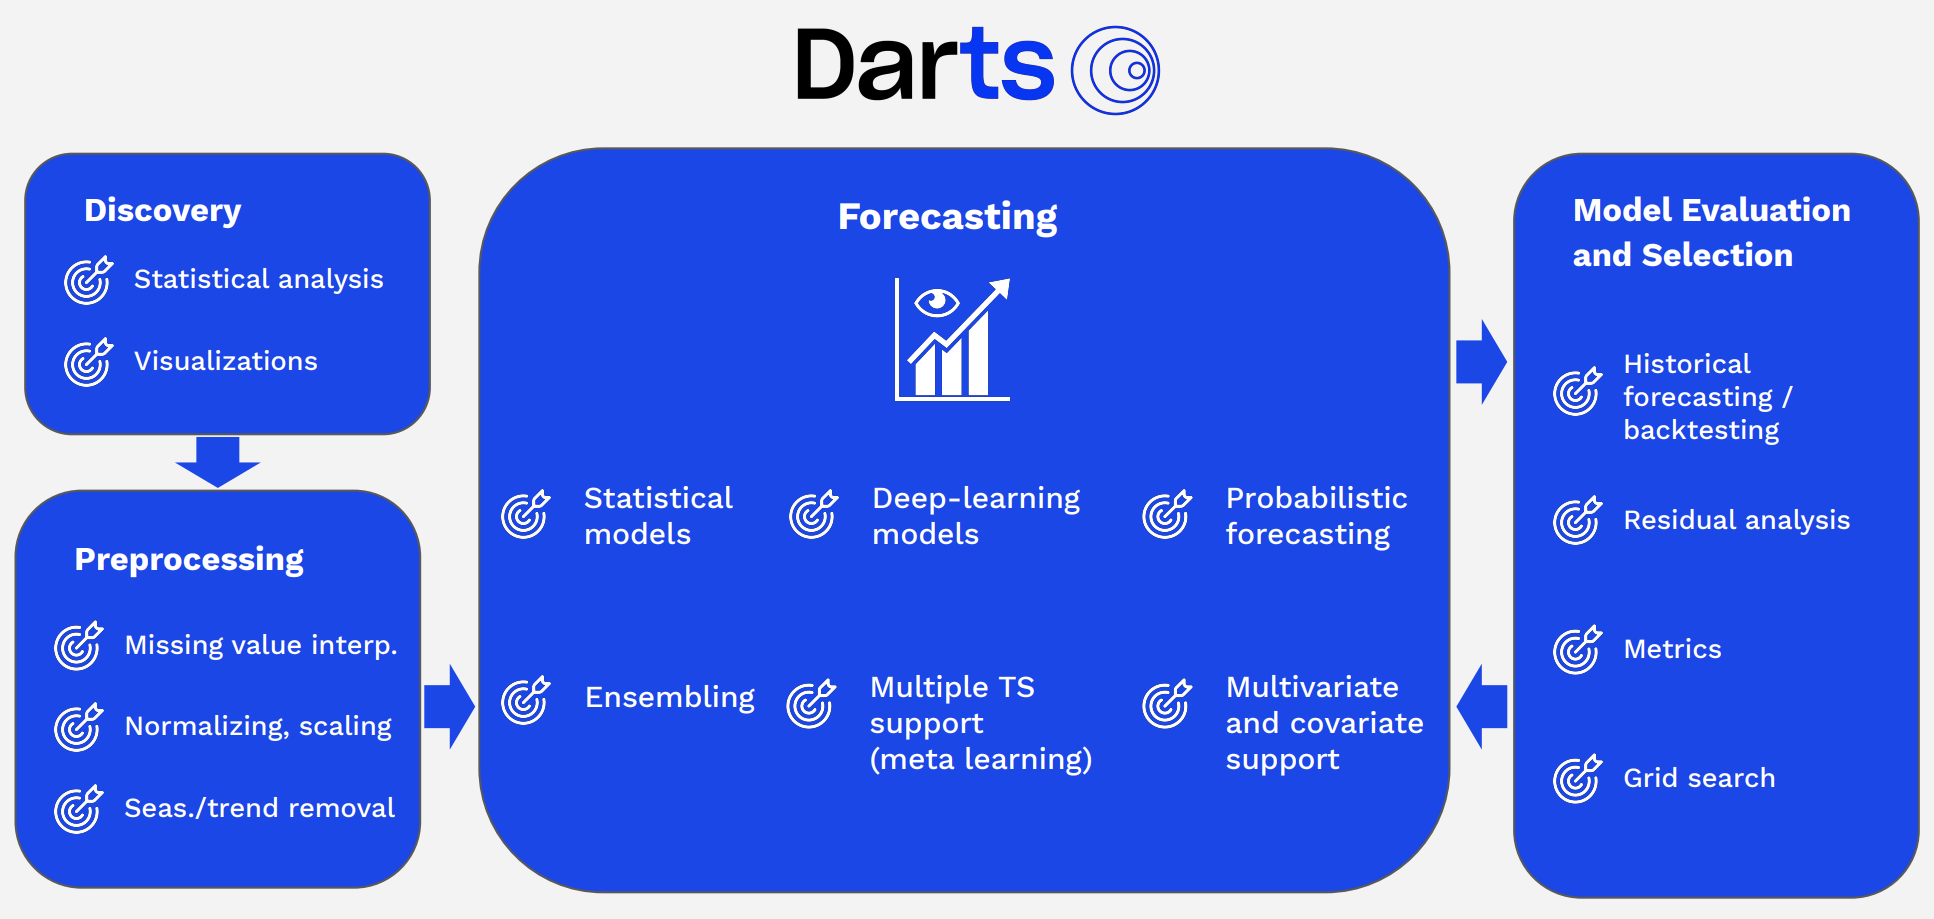

In [1]:
!pip install darts --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.9/846.9 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 13

**Import Libraries**

In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import pandas as pd
plt.rcParams['figure.figsize'] = (7,5)

import torch
from darts.metrics import mape, smape, mae, rmse
from darts import TimeSeries

from darts.utils.callbacks import TFMProgressBar

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

**Dataset**

https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95/about_data

In [128]:
#read csv file into dataframe
data_url = 'https://raw.githubusercontent.com/myconcordia/A2I2/main/nyc_collision_factors.csv'
df = pd.read_csv(data_url)
df.info(memory_usage='deep')
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7303 entries, 0 to 7302
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DATE                           7303 non-null   object 
 1   TIME                           7303 non-null   object 
 2   BOROUGH                        6920 non-null   object 
 3   ZIP CODE                       6919 non-null   float64
 4   LATITUDE                       7303 non-null   float64
 5   LONGITUDE                      7303 non-null   float64
 6   LOCATION                       7303 non-null   object 
 7   ON STREET NAME                 6238 non-null   object 
 8   CROSS STREET NAME              6166 non-null   object 
 9   OFF STREET NAME                761 non-null    object 
 10  NUMBER OF PERSONS INJURED      7303 non-null   int64  
 11  NUMBER OF PERSONS KILLED       7303 non-null   int64  
 12  NUMBER OF PEDESTRIANS INJURED  7303 non-null   i

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,11/10/2016,16:11:00,BROOKLYN,11208.0,40.662514,-73.872007,"(40.6625139, -73.8720068)",WORTMAN AVENUE,MONTAUK AVENUE,NaN,...,Failure to Yield Right-of-Way,Unspecified,NaN,NaN,NaN,TAXI,PASSENGER VEHICLE,NaN,NaN,NaN
1,11/10/2016,05:11:00,MANHATTAN,10013.0,40.721323,-74.008344,"(40.7213228, -74.0083444)",HUBERT STREET,HUDSON STREET,NaN,...,Failure to Yield Right-of-Way,NaN,NaN,NaN,NaN,PASSENGER VEHICLE,NaN,NaN,NaN,NaN
2,04/16/2016,09:15:00,BROOKLYN,11201.0,40.687999,-73.997563,"(40.6879989, -73.9975625)",HENRY STREET,WARREN STREET,NaN,...,Lost Consciousness,Lost Consciousness,NaN,NaN,NaN,PASSENGER VEHICLE,VAN,NaN,NaN,NaN
3,04/15/2016,10:20:00,QUEENS,11375.0,40.719228,-73.854542,"(40.7192276, -73.8545422)",NaN,NaN,67-64 FLEET STREET,...,Failure to Yield Right-of-Way,Failure to Yield Right-of-Way,Failure to Yield Right-of-Way,NaN,NaN,PASSENGER VEHICLE,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN
4,04/15/2016,10:35:00,BROOKLYN,11210.0,40.632147,-73.952731,"(40.6321467, -73.9527315)",BEDFORD AVENUE,CAMPUS ROAD,NaN,...,Failure to Yield Right-of-Way,Failure to Yield Right-of-Way,NaN,NaN,NaN,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN


**Creating numerical and categorical lists**

In [6]:
# distinction is based on the number of different values in the column
columns = list(df.columns)

#categorical and numerical columns
cat_columns = []
num_columns = []

for i in columns:
    if len(df[i].unique()) > 6:
        num_columns.append(i)
    else:
        cat_columns.append(i)

cat_columns = cat_columns[:-1]

print('Numerical features:', num_columns)
print('Categorical features:', cat_columns)

Numerical features: ['DATE', 'TIME', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME', 'NUMBER OF PERSONS INJURED', 'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3']
Categorical features: ['BOROUGH', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLISTS INJURED', 'NUMBER OF CYCLISTS KILLED', 'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5', 'VEHICLE TYPE CODE 4']


# **Exploratory Data Analysis**

In [ ]:
#Install Plotly, an interactive library
!pip install plotly --quiet

In [ ]:
import plotly.graph_objects as go

In [ ]:
df.columns

Index(['DATE', 'TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
       'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME',
       'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
       'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
       'NUMBER OF CYCLISTS INJURED', 'NUMBER OF CYCLISTS KILLED',
       'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
       'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
       'CONTRIBUTING FACTOR VEHICLE 5', 'VEHICLE TYPE CODE 1',
       'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4',
       'VEHICLE TYPE CODE 5'],
      dtype='object')

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ZIP CODE,6919.0,10900.746640,551.568724,10001.000000,10310.000000,11211.000000,11355.000000,11694.000000
LATITUDE,7303.0,40.717653,0.069437,40.502341,40.670865,40.723260,40.759527,40.909628
LONGITUDE,7303.0,-73.921406,0.083317,-74.248277,-73.980744,-73.933888,-73.864463,-73.702590
NUMBER OF PERSONS INJURED,7303.0,0.350678,0.707873,0.000000,0.000000,0.000000,1.000000,16.000000
NUMBER OF PERSONS KILLED,7303.0,0.000959,0.030947,0.000000,0.000000,0.000000,0.000000,1.000000
NUMBER OF PEDESTRIANS INJURED,7303.0,0.133644,0.362129,0.000000,0.000000,0.000000,0.000000,3.000000
NUMBER OF PEDESTRIANS KILLED,7303.0,0.000822,0.028653,0.000000,0.000000,0.000000,0.000000,1.000000
NUMBER OF CYCLISTS INJURED,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NUMBER OF CYCLISTS KILLED,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import plotly.express as px

# Groupping by ON STREET NAME and CROSS STREET NAME
df_summary = df.groupby(['ON STREET NAME', 'CROSS STREET NAME'])['NUMBER OF CYCLISTS INJURED'].sum().reset_index()

# Create a nested pie chart
px.sunburst(df_summary,
            path=['ON STREET NAME', 'CROSS STREET NAME'],
            values='NUMBER OF CYCLISTS INJURED')


**Checking for missing values**

In [ ]:
# find the number of missing values in each column
print("Number of missing values in each column is :")
df.isnull().sum()

Number of missing values in each column is :


DATE                                0
TIME                                0
BOROUGH                           383
ZIP CODE                          384
LATITUDE                            0
LONGITUDE                           0
LOCATION                            0
ON STREET NAME                   1065
CROSS STREET NAME                1137
OFF STREET NAME                  6542
NUMBER OF PERSONS INJURED           0
NUMBER OF PERSONS KILLED            0
NUMBER OF PEDESTRIANS INJURED       0
NUMBER OF PEDESTRIANS KILLED        0
NUMBER OF CYCLISTS INJURED       7303
NUMBER OF CYCLISTS KILLED        7303
CONTRIBUTING FACTOR VEHICLE 1       0
CONTRIBUTING FACTOR VEHICLE 2    1085
CONTRIBUTING FACTOR VEHICLE 3    7000
CONTRIBUTING FACTOR VEHICLE 4    7244
CONTRIBUTING FACTOR VEHICLE 5    7289
VEHICLE TYPE CODE 1                58
VEHICLE TYPE CODE 2              1520
VEHICLE TYPE CODE 3              7019
VEHICLE TYPE CODE 4              7249
VEHICLE TYPE CODE 5              7291
dtype: int64

In [ ]:
# Calculate the percentage of missing values for each column
missing_percentages = (df.isnull().sum() / len(df)) * 100

# Create a bar chart
fig = go.Figure(data=[go.Bar(
    x=missing_percentages.index,
    y=missing_percentages.values,
    marker_color='lightsalmon'  # Adjust the color as needed
)])

# Update layout
fig.update_layout(
    title='Percentage of Missing Values in Each Column',
    xaxis_title='Columns',
    yaxis_title='Percentage Missing (%)'
)

# Show the plot
fig.show()

**Analysis of Missing Data by Visualisation**

<Axes: >

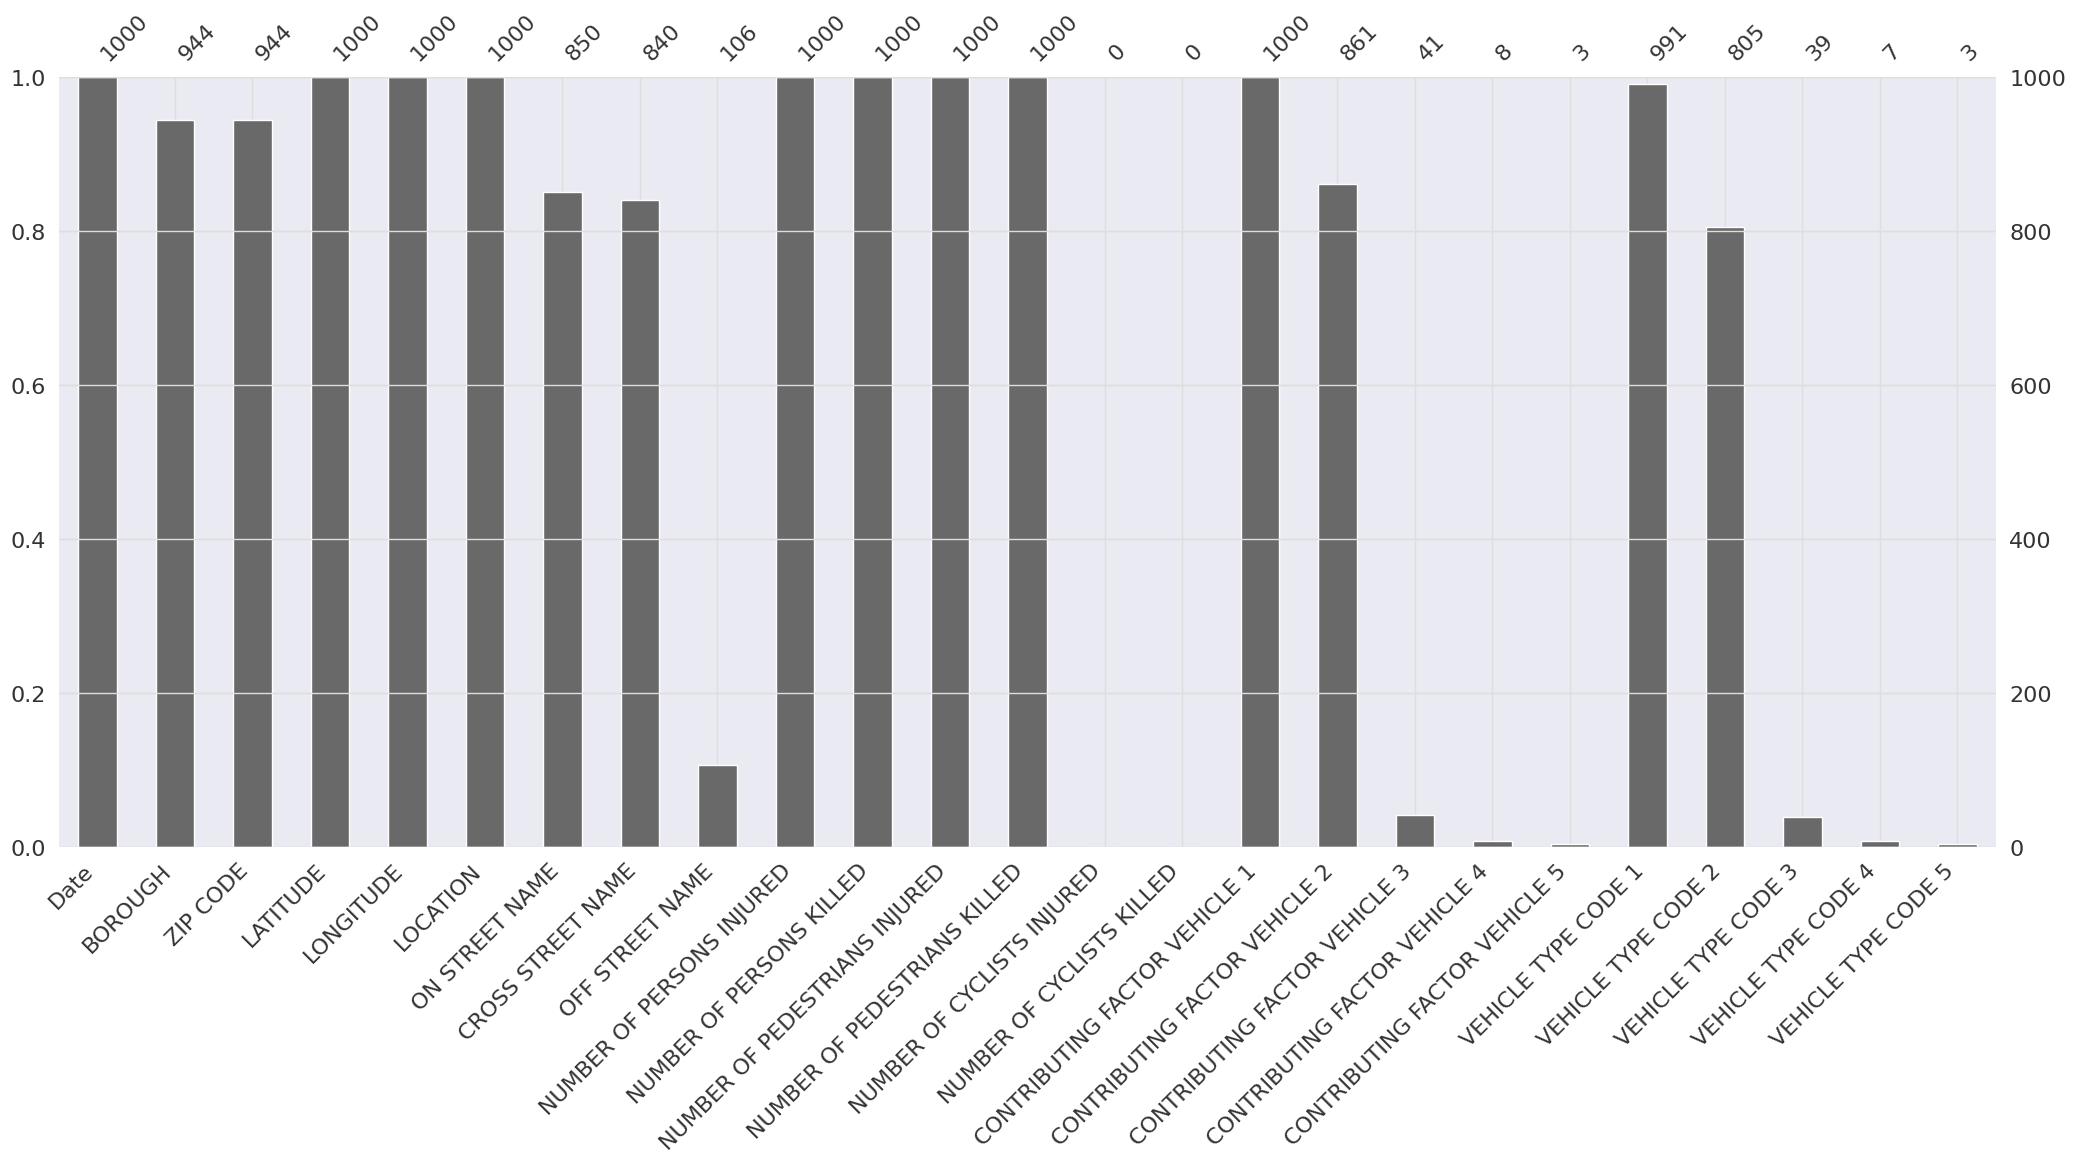

In [ ]:
# Import missingno for missing data visualization
import missingno as msno
# Plot amount of missingness (visualization of nullity by column)
msno.bar(df.sample(1000))

<Axes: >

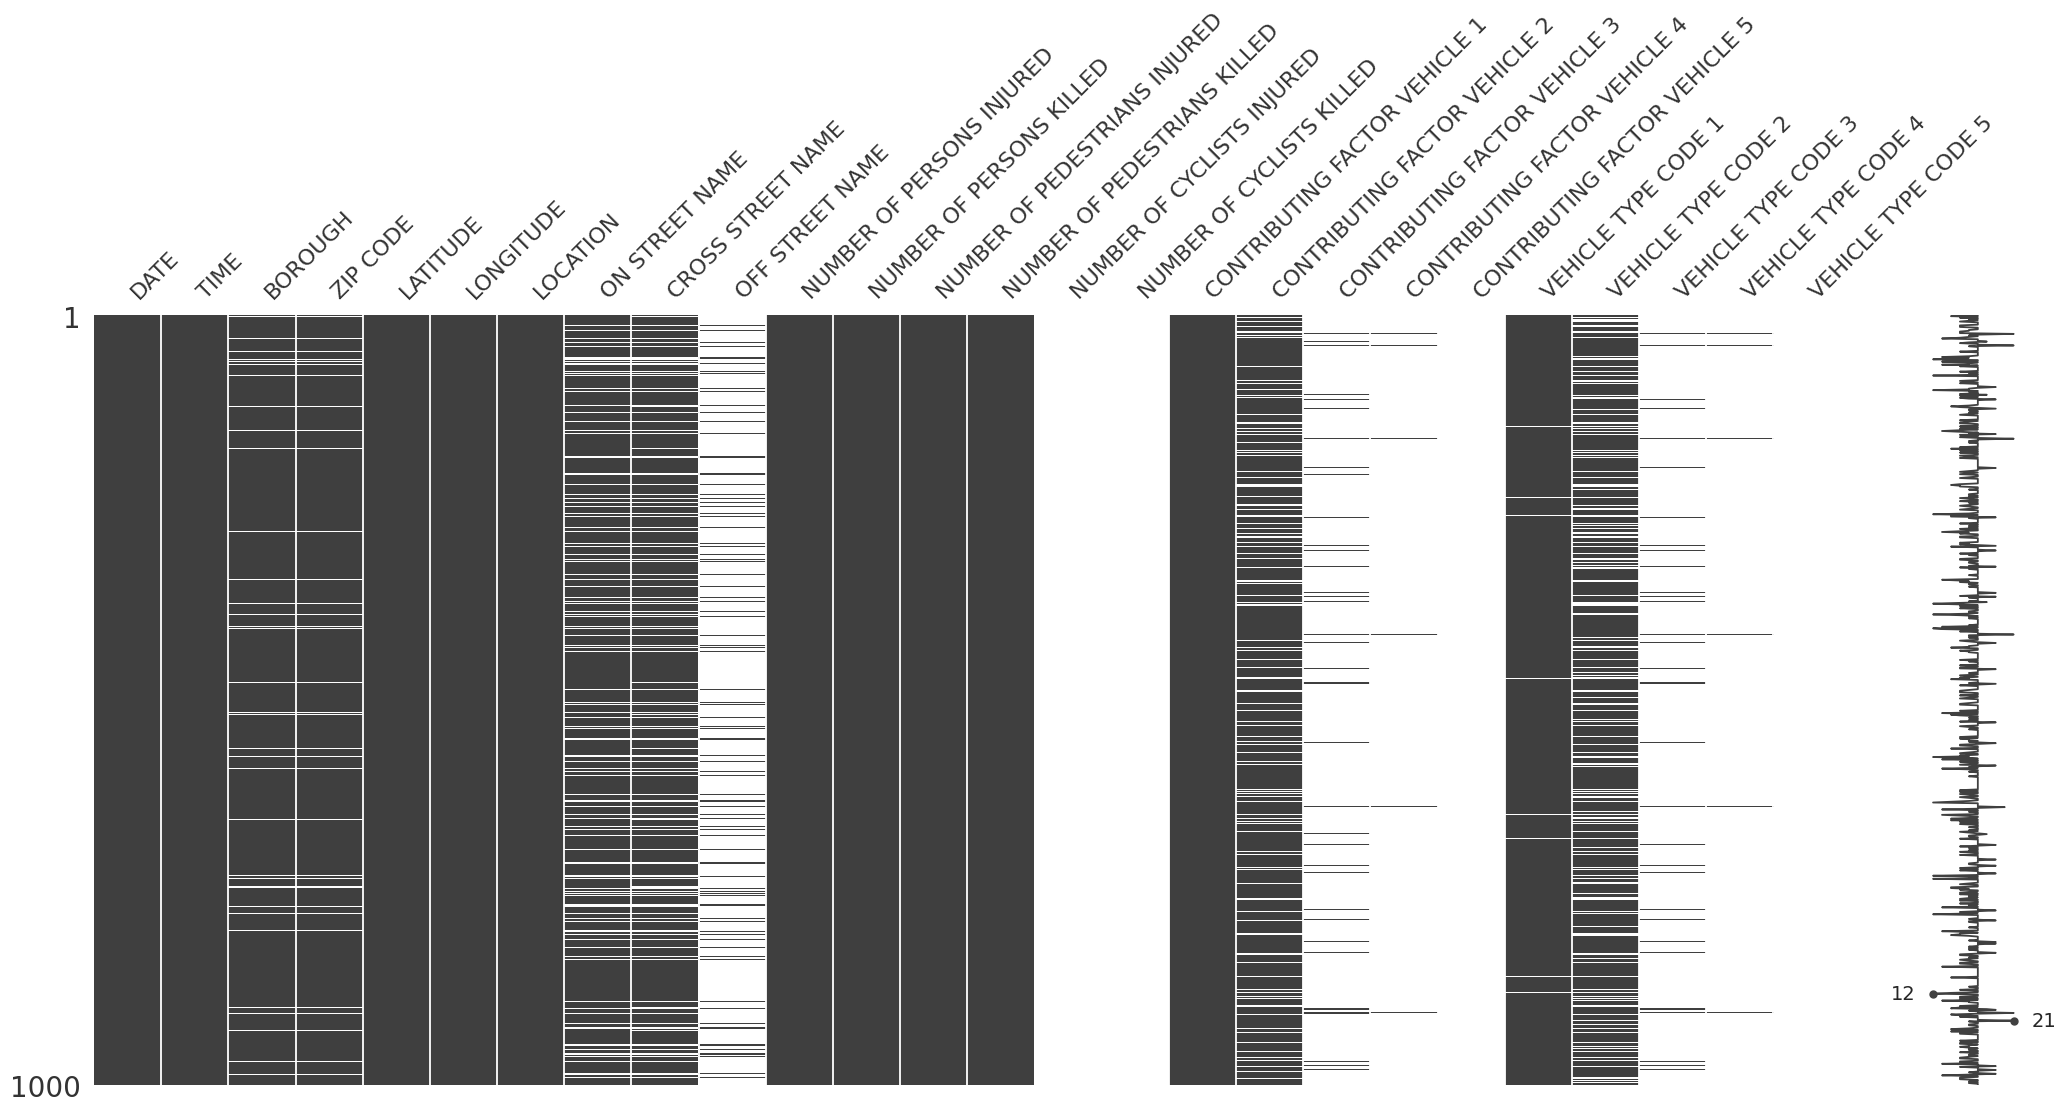

In [ ]:
msno.matrix(df.sample(1000))

The sparkline on the right right summarizes the general shape of the data completeness and points out the rows with the maximum and minimum nullity in the dataset.

<Axes: >

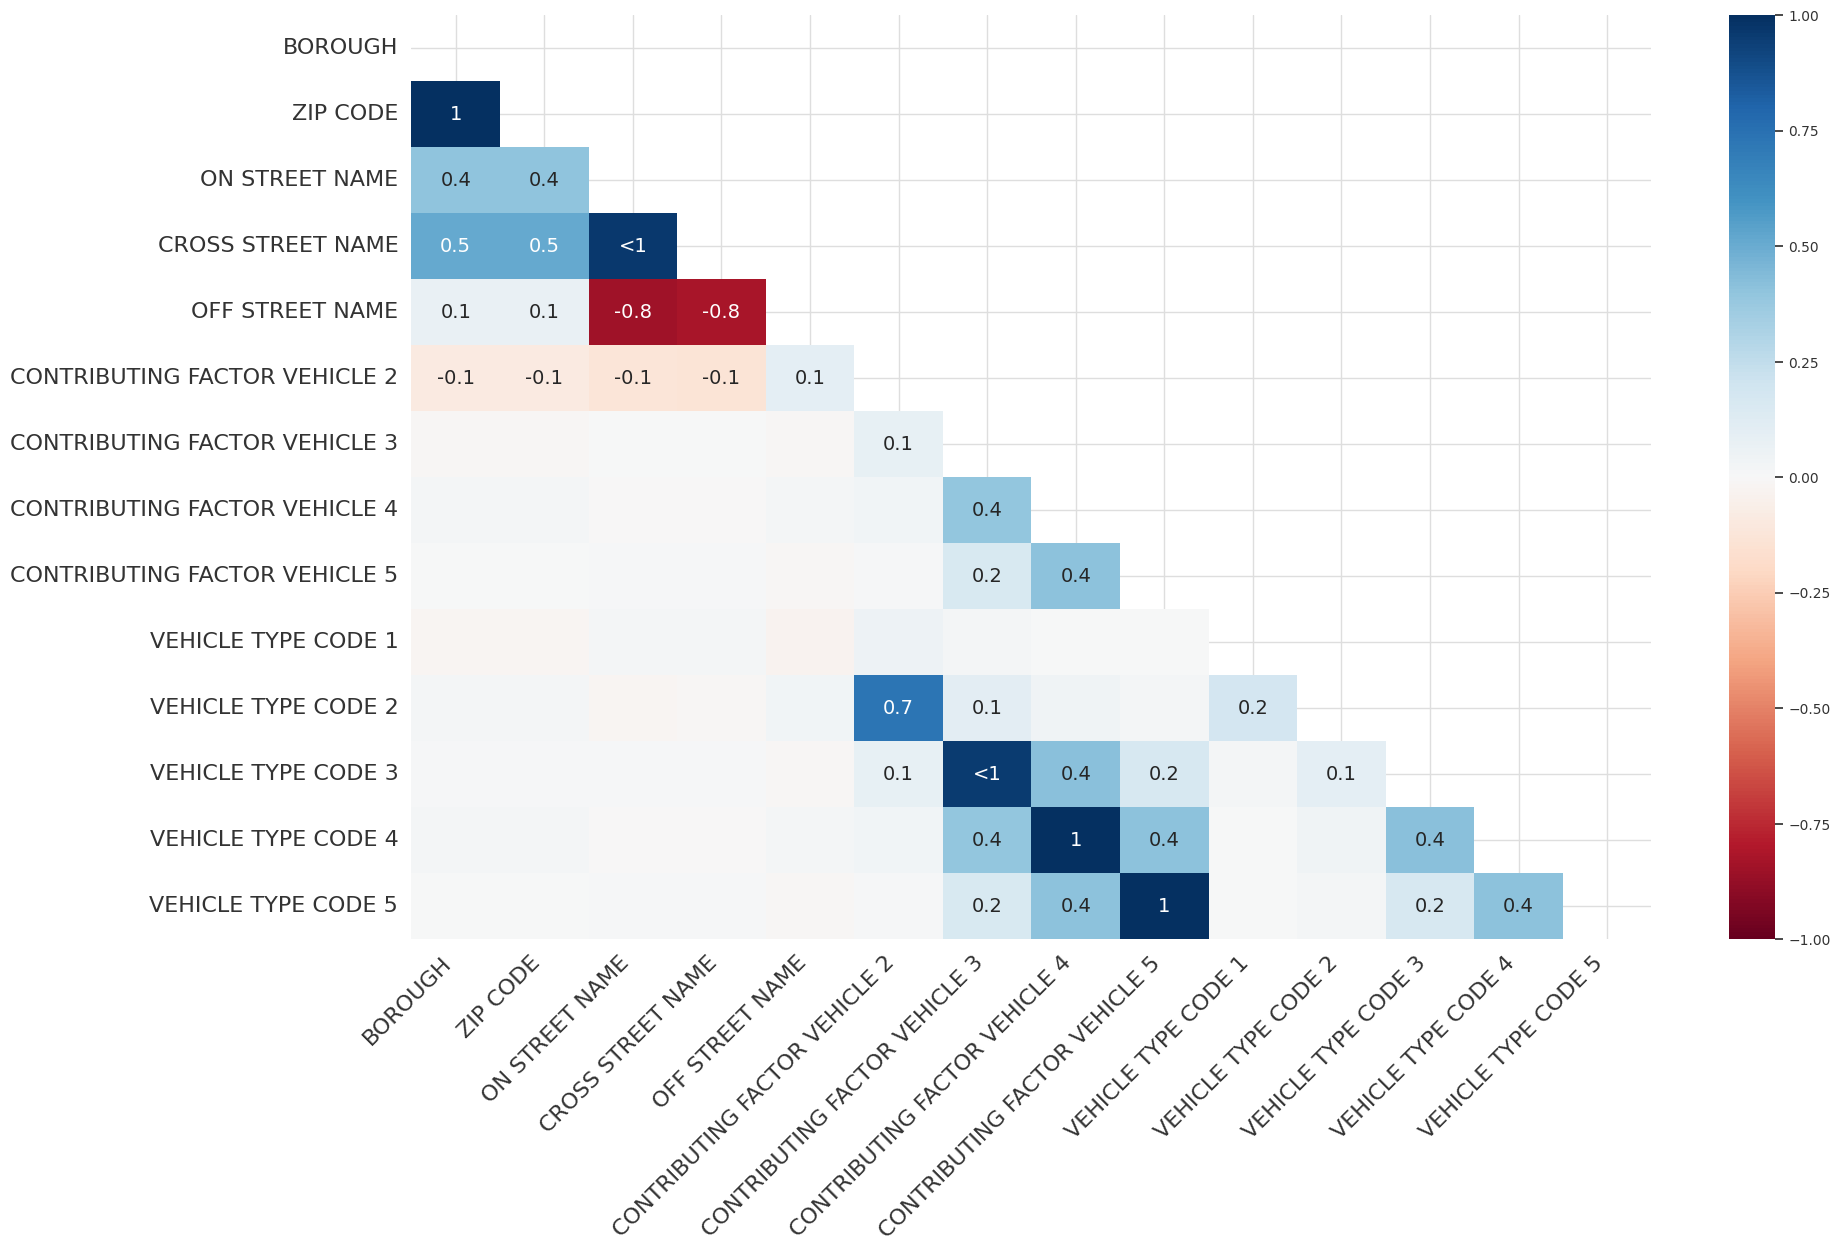

In [ ]:
msno.heatmap(df.sample(1000))

**Checking for Duplicates Values**

It's also necessary to check for any duplicate entries in the dataset. The duplicate entries will cause redundency so it's better to remove duplicates from the dataset.

In [ ]:
# Identify duplicate rows
duplicates = df[df.duplicated(keep=False)]

# Print the duplicate rows
if len(duplicates) > 0:
    print('Duplicate Rows:')
    print(duplicates)
else:
    print('No duplicates found.')

print("Total Duplicate Entries: ", len(duplicates))

Duplicate Rows:
            DATE      TIME    BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
1351  04/06/2016  10:30:00  MANHATTAN   10014.0  40.729112 -74.010672   
1695  03/14/2016  15:00:00     QUEENS   11103.0  40.760946 -73.916293   
1696  03/14/2016  15:00:00     QUEENS   11103.0  40.760946 -73.916293   
1818  03/27/2016  10:00:00     QUEENS   11411.0  40.698018 -73.744018   
1819  03/27/2016  10:00:00     QUEENS   11411.0  40.698018 -73.744018   
3323  03/23/2016  00:05:00  MANHATTAN   10001.0  40.752723 -73.996788   
3324  03/23/2016  00:05:00  MANHATTAN   10001.0  40.752723 -73.996788   
4027  02/17/2016  08:51:00        NaN       NaN  40.703166 -73.816612   
4028  02/17/2016  08:51:00        NaN       NaN  40.703166 -73.816612   
5042  04/06/2016  10:30:00  MANHATTAN   10014.0  40.729112 -74.010672   
5636  01/05/2016  08:00:00   BROOKLYN   11206.0  40.703375 -73.937631   
5637  01/05/2016  08:00:00   BROOKLYN   11206.0  40.703375 -73.937631   
6317  04/08/2016  16:25:00     QUEE

In [ ]:
# Remove duplicate rows
df = df.drop_duplicates()

**Combine DATE and TIME** into a new column Date. Then, drop both and move the last column to the first position.

In [ ]:
df['Date'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'])
df = df.drop(columns=['DATE', 'TIME'])
cols = df.columns.tolist()
df = df[cols[-1:] + cols[:-1]]
df.head()

,Date,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,...,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,2016-11-10 16:11:00,BROOKLYN,11208.0,40.662514,-73.872007,"(40.6625139, -73.8720068)",WORTMAN AVENUE,MONTAUK AVENUE,NaN,0,...,Failure to Yield Right-of-Way,Unspecified,NaN,NaN,NaN,TAXI,PASSENGER VEHICLE,NaN,NaN,NaN
1,2016-11-10 05:11:00,MANHATTAN,10013.0,40.721323,-74.008344,"(40.7213228, -74.0083444)",HUBERT STREET,HUDSON STREET,NaN,1,...,Failure to Yield Right-of-Way,NaN,NaN,NaN,NaN,PASSENGER VEHICLE,NaN,NaN,NaN,NaN
2,2016-04-16 09:15:00,BROOKLYN,11201.0,40.687999,-73.997563,"(40.6879989, -73.9975625)",HENRY STREET,WARREN STREET,NaN,0,...,Lost Consciousness,Lost Consciousness,NaN,NaN,NaN,PASSENGER VEHICLE,VAN,NaN,NaN,NaN
3,2016-04-15 10:20:00,QUEENS,11375.0,40.719228,-73.854542,"(40.7192276, -73.8545422)",NaN,NaN,67-64 FLEET STREET,0,...,Failure to Yield Right-of-Way,Failure to Yield Right-of-Way,Failure to Yield Right-of-Way,NaN,NaN,PASSENGER VEHICLE,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN
4,2016-04-15 10:35:00,BROOKLYN,11210.0,40.632147,-73.952731,"(40.6321467, -73.9527315)",BEDFORD AVENUE,CAMPUS ROAD,NaN,0,...,Failure to Yield Right-of-Way,Failure to Yield Right-of-Way,NaN,NaN,NaN,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN


<Axes: >

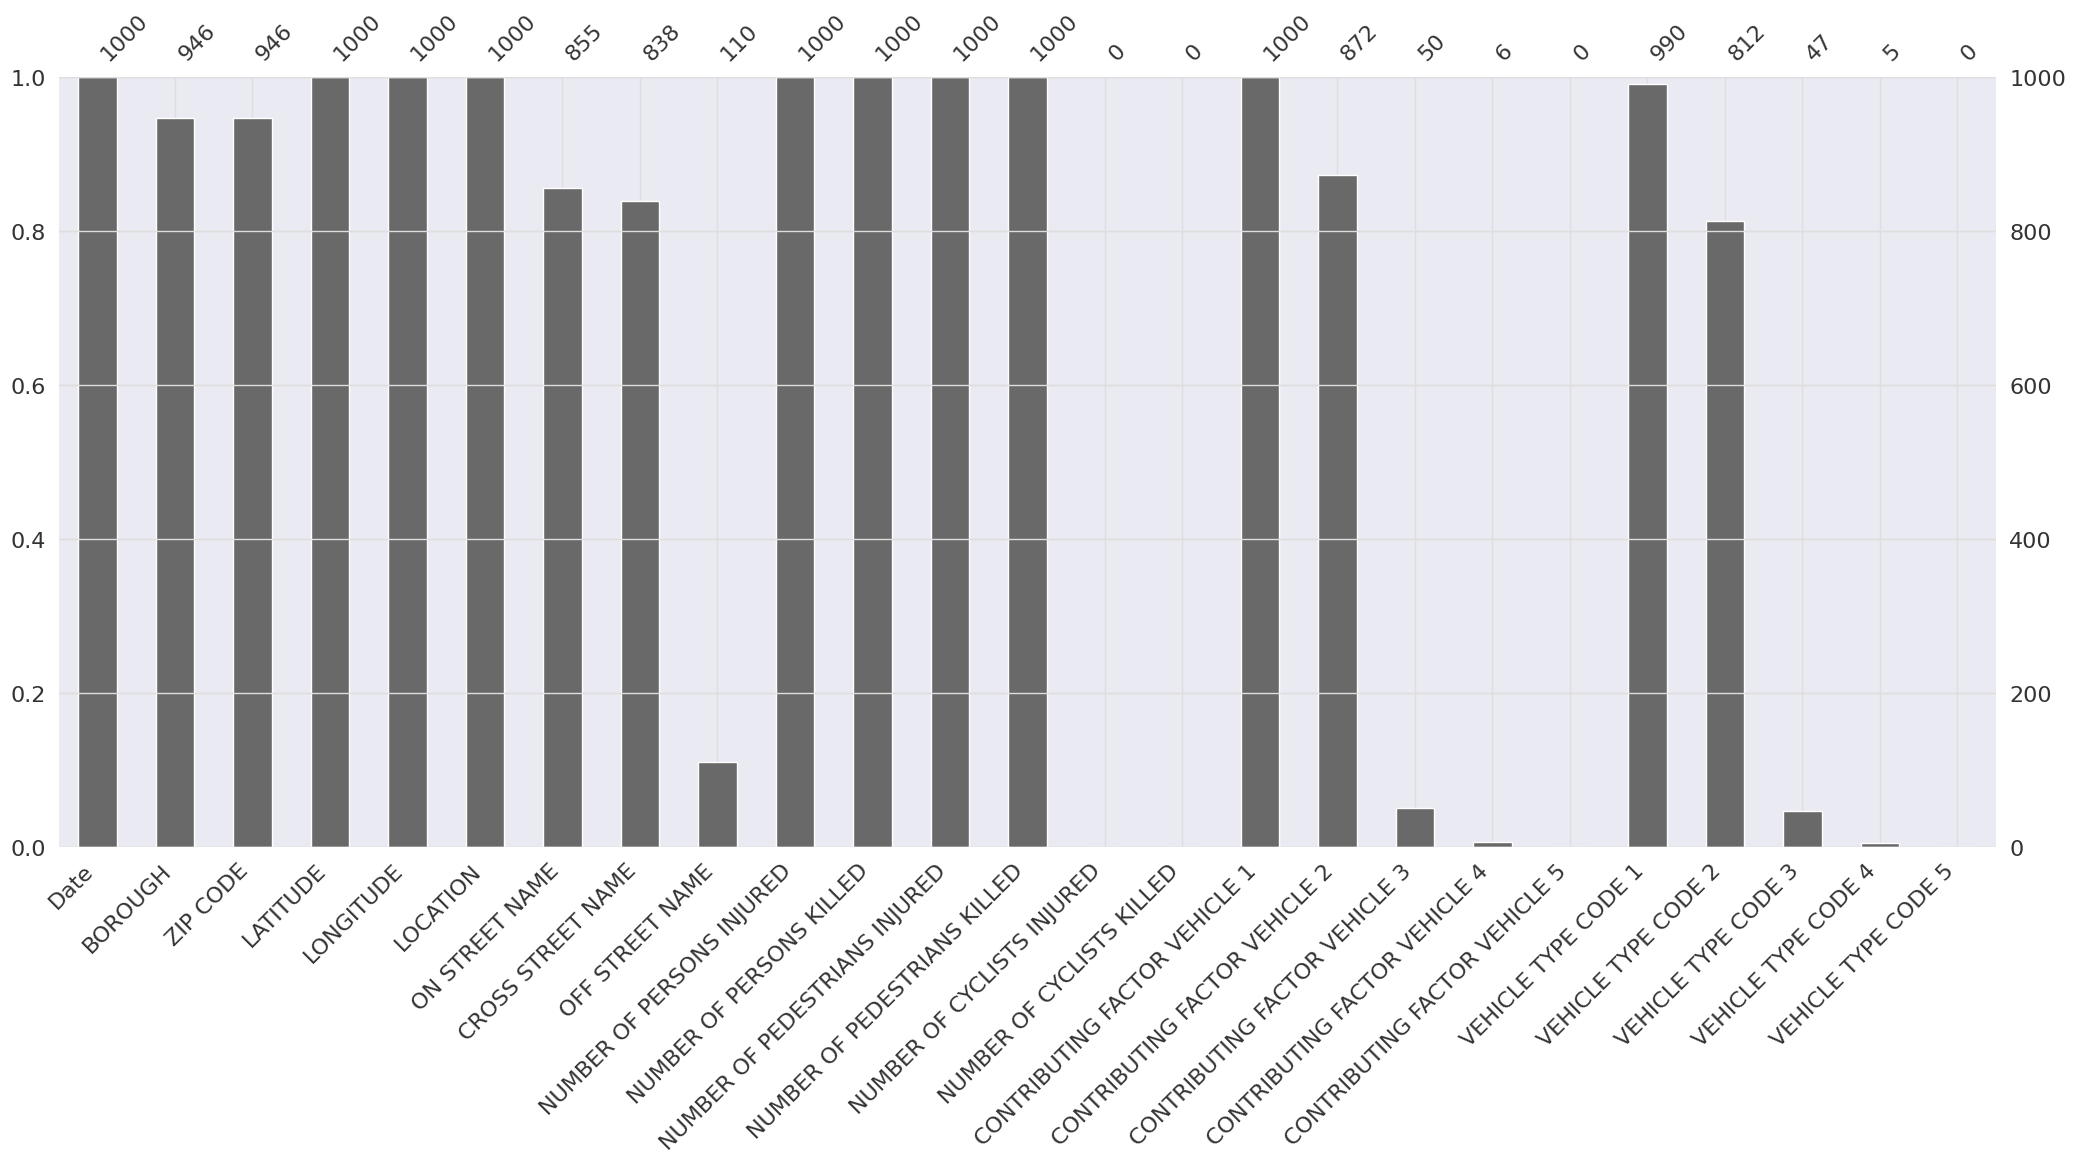

In [ ]:
msno.bar(df.sample(1000))

<Axes: >

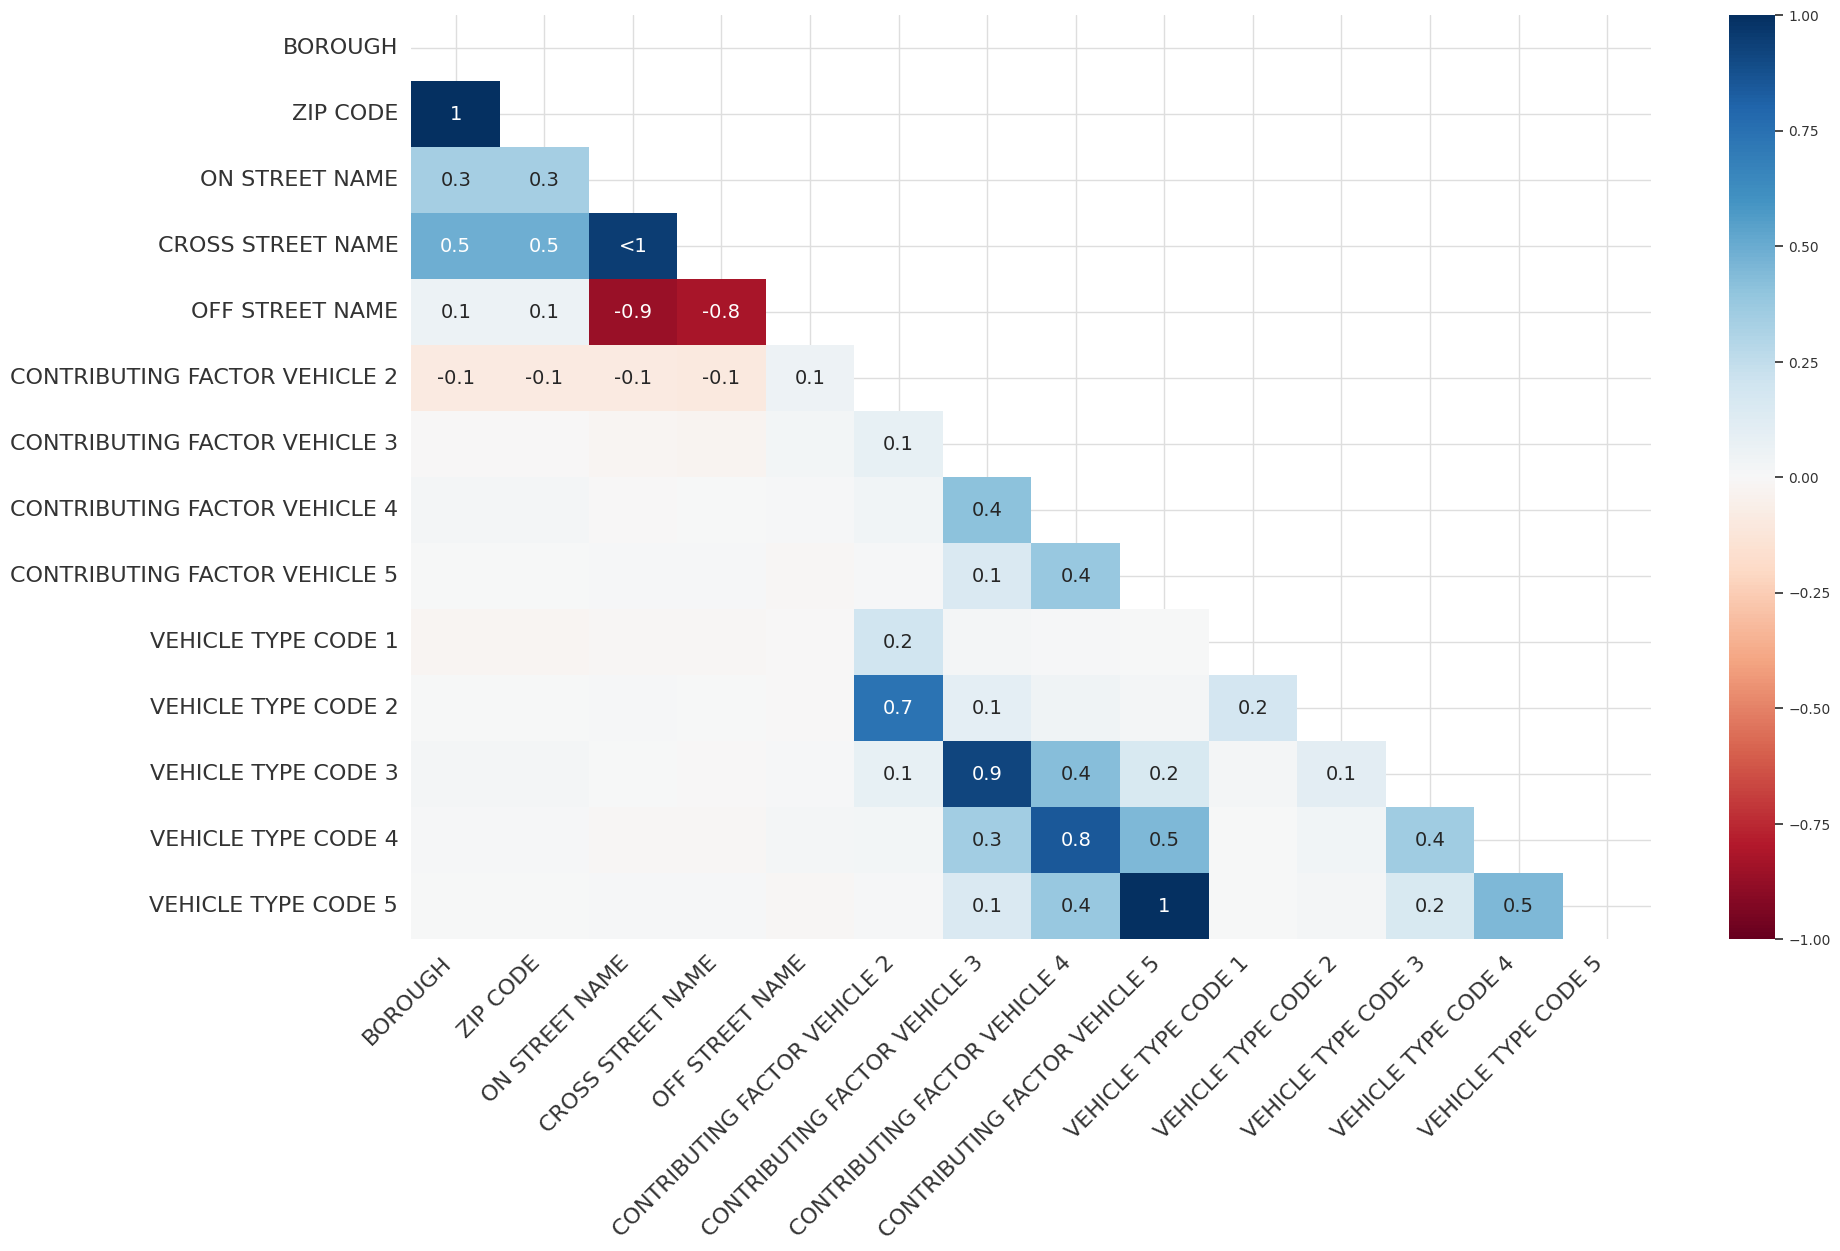

In [ ]:
msno.heatmap(df.sample(1000))

**Simple Imputation**

strategy = {‘mean’, ‘median’, ‘most_frequent’, ‘constant’}, default=’mean’

The imputation strategy.

If “mean”, then replace missing values using the mean along each column. Can only be used with numeric data.

If “median”, then replace missing values using the median along each column. Can only be used with numeric data.

If “most_frequent”, then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.

If “constant”, then replace missing values with fill_value. Can be used with strings or numeric data.

In [7]:
print('Categorical features:', cat_columns)

Categorical features: ['BOROUGH', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLISTS INJURED', 'NUMBER OF CYCLISTS KILLED', 'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5', 'VEHICLE TYPE CODE 4']


In [129]:
from sklearn.impute import SimpleImputer

# Selecting some categorical features
cat_features = ['ON STREET NAME', 'OFF STREET NAME']

# Simple Imputation: {‘mean’, ‘median’, ‘most_frequent’, ‘constant’}, default=’mean’
sim_imputer = SimpleImputer(strategy='most_frequent')
sim_imputed = sim_imputer.fit_transform(df[cat_features])
df_sim_imputed = pd.DataFrame(sim_imputed, columns=cat_features)

df_simple_joint = pd.concat([df[cat_features], df_sim_imputed], axis=1, join='inner')
df_simple_joint[25:45]

,ON STREET NAME,OFF STREET NAME,ON STREET NAME,OFF STREET NAME
25,5 AVENUE,NaN,5 AVENUE,141-40 NORTHERN BOULEVARD
26,72 STREET,NaN,72 STREET,141-40 NORTHERN BOULEVARD
27,NaN,961 EAST 174 STREET,BROADWAY,961 EAST 174 STREET
28,EMPIRE BOULEVARD,NaN,EMPIRE BOULEVARD,141-40 NORTHERN BOULEVARD
29,130 AVENUE,NaN,130 AVENUE,141-40 NORTHERN BOULEVARD
30,149 STREET,NaN,149 STREET,141-40 NORTHERN BOULEVARD
31,UTOPIA PARKWAY,NaN,UTOPIA PARKWAY,141-40 NORTHERN BOULEVARD
32,48 AVENUE,NaN,48 AVENUE,141-40 NORTHERN BOULEVARD
33,FLATBUSH AVENUE,NaN,FLATBUSH AVENUE,141-40 NORTHERN BOULEVARD
34,65 PLACE,NaN,65 PLACE,141-40 NORTHERN BOULEVARD


**Encoding Categorical Variables**

Label Encoding converts categorical variables into numerical labels. It assigns a unique numerical value to each category within a feature.

In [130]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_encoded = df_sim_imputed.copy()  # Create a copy of the DataFrame for encoded values

# Apply label encoding to each categorical column
for column in cat_features:
    df_encoded[column] = label_encoder.fit_transform(df_encoded[column])

df_encoded_joint = pd.concat([df[cat_features], df_encoded], axis=1, join='inner')
df_encoded_joint[25:45]

,ON STREET NAME,OFF STREET NAME,ON STREET NAME,OFF STREET NAME
25,5 AVENUE,NaN,262,148
26,72 STREET,NaN,325,148
27,NaN,961 EAST 174 STREET,514,732
28,EMPIRE BOULEVARD,NaN,858,148
29,130 AVENUE,NaN,51,148
30,149 STREET,NaN,85,148
31,UTOPIA PARKWAY,NaN,1433,148
32,48 AVENUE,NaN,256,148
33,FLATBUSH AVENUE,NaN,879,148
34,65 PLACE,NaN,301,148


In [134]:
from sklearn.preprocessing import LabelEncoder
df_encoded = df_sim_imputed.apply(LabelEncoder().fit_transform)
df_encoded_joint = pd.concat([df[cat_features], df_encoded], axis=1, join='inner')
df_encoded_joint[25:45]

,ON STREET NAME,OFF STREET NAME,ON STREET NAME,OFF STREET NAME
25,5 AVENUE,NaN,262,148
26,72 STREET,NaN,325,148
27,NaN,961 EAST 174 STREET,514,732
28,EMPIRE BOULEVARD,NaN,858,148
29,130 AVENUE,NaN,51,148
30,149 STREET,NaN,85,148
31,UTOPIA PARKWAY,NaN,1433,148
32,48 AVENUE,NaN,256,148
33,FLATBUSH AVENUE,NaN,879,148
34,65 PLACE,NaN,301,148


**One Hot Encoding**

In [133]:
from sklearn.preprocessing import OneHotEncoder

# Create a copy of the DataFrame for encoded values
ohe_encoded = df_sim_imputed.copy()
# Apply one hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe_encoded = ohe.fit_transform(df_encoded[cat_features])
ohe_encoded  = pd.DataFrame(ohe_encoded)

df_encoded_joint = pd.concat([df[cat_features], ohe_encoded], axis=1, join='inner')
df_encoded_joint[25:45]

,ON STREET NAME,OFF STREET NAME,0,1,2,3,4,5,6,7,...,2418,2419,2420,2421,2422,2423,2424,2425,2426,2427
25,5 AVENUE,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,72 STREET,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,NaN,961 EAST 174 STREET,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,EMPIRE BOULEVARD,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,130 AVENUE,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,149 STREET,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,UTOPIA PARKWAY,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,48 AVENUE,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,FLATBUSH AVENUE,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,65 PLACE,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Ordinal Encoding**

In [109]:
from sklearn.preprocessing import OrdinalEncoder

# Create a copy of the DataFrame for encoded values
ord_encoded = df_sim_imputed.copy()
# Apply ordinal encoder
ord = OrdinalEncoder(handle_unknown='error')
ord_encoded = ord.fit_transform(df_encoded[cat_features])
ord_encoded = pd.DataFrame(ord_encoded, columns=df[cat_features].columns)

df_encoded_joint = pd.concat([df[cat_features], ord_encoded], axis=1, join='inner')
df_encoded_joint[25:45]

,ON STREET NAME,OFF STREET NAME,ON STREET NAME,OFF STREET NAME
25,5 AVENUE,NaN,262.0,148.0
26,72 STREET,NaN,325.0,148.0
27,NaN,961 EAST 174 STREET,514.0,732.0
28,EMPIRE BOULEVARD,NaN,858.0,148.0
29,130 AVENUE,NaN,51.0,148.0
30,149 STREET,NaN,85.0,148.0
31,UTOPIA PARKWAY,NaN,1433.0,148.0
32,48 AVENUE,NaN,256.0,148.0
33,FLATBUSH AVENUE,NaN,879.0,148.0
34,65 PLACE,NaN,301.0,148.0


# **Feature Engineering**

In [110]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.7 MB/s eta 0:00:00


In [115]:
import category_encoders as ce

ohe = ce.OneHotEncoder(cols=cat_features)
df_ohe = ohe.fit_transform(df[cat_features])
df_ohe.head()

,ON STREET NAME_1,ON STREET NAME_2,ON STREET NAME_3,ON STREET NAME_4,ON STREET NAME_5,ON STREET NAME_6,ON STREET NAME_7,ON STREET NAME_8,ON STREET NAME_9,ON STREET NAME_10,...,OFF STREET NAME_749,OFF STREET NAME_750,OFF STREET NAME_751,OFF STREET NAME_752,OFF STREET NAME_753,OFF STREET NAME_754,OFF STREET NAME_755,OFF STREET NAME_756,OFF STREET NAME_757,OFF STREET NAME_758
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
#!pip install feature_engine